In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp
from collections import deque
import matplotlib.pyplot as plt
from previous_lesson1 import extractPoseKeypoints
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.utils import plot_model

In [2]:
# Initialize the mediapipe pose class.
mp_pose = mp.solutions.pose

# Set up the pose landmarks function for videos.
pose_videos = mp_pose.Pose(static_image_mode=False, model_complexity=1, smooth_landmarks=True, 
                           enable_segmentation=True, smooth_segmentation=True, 
                           min_detection_confidence=0.5, min_tracking_confidence=0.8)

In [3]:
# Specify the path where the dataset is stored.
DATASET_DIR = 'dataset'

# Specify the number of frames of a video that will be fed to the model as one sequence.
sequence_length = 30 

# Initialize the list containing the classes on which we want to train our model.
classes_list = ["Hello", "bye", "Thankyou"]

In [4]:
# Initialize lists to store the landmarks and labels.
landmarks, labels = [], []

# Iterate over the classes.
for class_index, label in enumerate(classes_list):
    
    # Get the directory path of the class, we are iterating upon. 
    dir_path = os.path.join(DATASET_DIR, label)
    
    # Check if the directory exists.
    if os.path.exists(dir_path):
        
        # Get the files names in the directory.
        file_names = os.listdir(dir_path)
        
        # Iterate over the files names.
        for file_name in file_names:
            
            # Load the landmarks data from the file.
            video_landmarks = np.load(os.path.join(dir_path, file_name))
            
            # Append the landmarks into the list.
            landmarks.append(video_landmarks)
            
            # Append the label index into the list.
            labels.append(class_index)

# Convert the landmarks list into an array.           
landmarks = np.array(landmarks)

# Convert labels into one-hot-encoded vectors using Keras's to_categorical function.
labels = to_categorical(labels).astype(int)

# Display the success message. 
print(f"Data loaded successfully.")    

Data loaded successfully.


In [5]:
# Split the dataset into random train and test subsets.
train_landmarks, test_landmarks, train_labels, test_labels = train_test_split(landmarks, labels, test_size=0.05)

In [6]:
# Check the input Shape
print(train_landmarks[0].shape)

(30, 66)


In [7]:
# We will use a Sequential model.
model = Sequential()

# Define the Model Architecture.
####################################################################################################    
model.add(LSTM(64, return_sequences=True, activation='relu',
               input_shape=train_landmarks[0].shape))

model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(len(classes_list), activation='softmax'))
####################################################################################################

# Display the model's summary.
model.summary()
    
# Display the success message. 
print("Model Created Successfully!")

c:\Users\Bhavith\.conda\envs\finalYear\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        33,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 779,459 (2.97 MB)

 Trainable params: 779,459 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


In [8]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
model_training_history = model.fit(x = train_landmarks, y = train_labels, epochs = 200, batch_size = 16,
                                   callbacks = [early_stopping_callback],
                                   validation_split = 0.2, shuffle = True)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.3789 - loss: 1.0927 - val_accuracy: 0.2353 - val_loss: 1.0499
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4300 - loss: 0.9598 - val_accuracy: 0.2353 - val_loss: 4.6116
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2777 - loss: 1.4423 - val_accuracy: 0.7647 - val_loss: 0.6477
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5476 - loss: 0.9048 - val_accuracy: 0.4118 - val_loss: 1.0628
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6914 - loss: 0.9740 - val_accuracy: 0.2353 - val_loss: 1.0491
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5112 - loss: 0.9313 - val_accuracy: 0.7647 - val_loss: 0.8911
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6046 - loss: 0.7304 - val_accuracy: 0.7647 - val_loss: 0.6559
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7225 - loss: 0.5523 - val_accuracy: 1.0000 - val_los

In [10]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

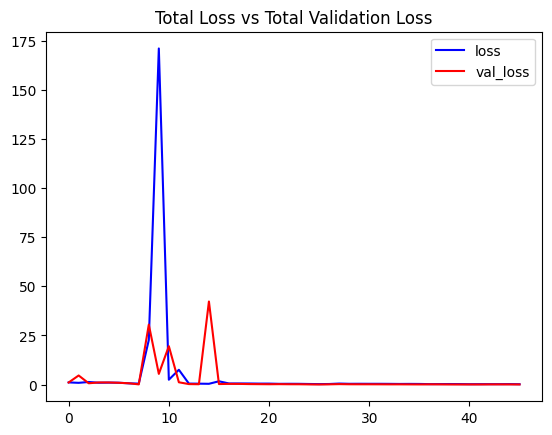

In [11]:
# Visualize the training and validation loss metrices.
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

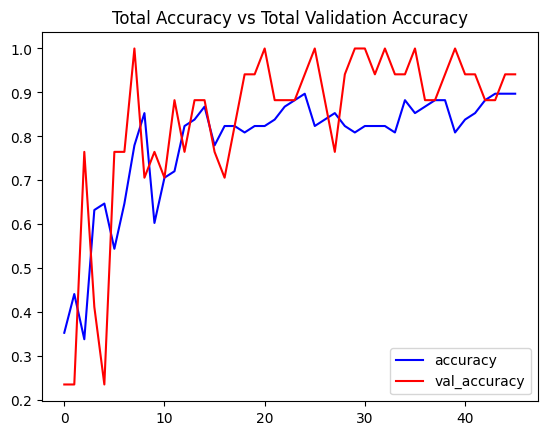

In [12]:
# Visualize the training and validation accuracy metrices.
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [13]:
# Specify the path of the directory in which you want to store the model.
model_dir = 'Model'

# Check if the directory does not already exist.
if not os.path.exists(model_dir):
    
    # Create the directory.
    os.mkdir(model_dir)

# Save the Model.
model.save(f'{model_dir}/sign_language_recognizer.h5')

In [14]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Sign Language Recognition', cv2.WINDOW_NORMAL)

# Load the model from disk.
loaded_model = load_model('Model/sign_language_recognizer.h5')

# Initialize a deque to store the frames.
sequence = deque([], maxlen=sequence_length)

# Initialize a variable to store the buffer length.
BUFFER_MAX_LENGTH = 20

# Initialize a buffer to store the prediction results.
buffer = deque([], maxlen=BUFFER_MAX_LENGTH)

# Initialize a variable to store the minimum prediction confidence.
threshold = 0.55

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():

    # Read a frame.
    ok, frame = camera_video.read()

    # Check if frame is not read properly then
    # continue to the next iteration to read the next frame.
    if not ok:
        continue

    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)

    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape

    # Extract the required pose keypoints of the person in the frame.
    frame, extracted_keypoints = extractPoseKeypoints(frame, pose_videos)

    # Print the shape of extracted_keypoints for debugging.
    print("Shape of extracted_keypoints:", extracted_keypoints.shape)

    # Only append the extracted keypoints into the deque if it's not empty.
    if extracted_keypoints.shape != (0,):
        sequence.append(extracted_keypoints)

    # Print the length of sequence for debugging.
    print("Length of sequence:", len(sequence))

    # Check if the length of the deque is equal to the required sequence length.
    if len(sequence) == sequence_length:

        # Predict the Sign, the person is making in the sequence.
        prediction_probs = loaded_model.predict(np.expand_dims(sequence, axis=0))[0]

        # Check if the highest predicted probability of a class is > the threshold value.
        if prediction_probs[np.argmax(prediction_probs)] > threshold:

            # Get the class (Sign) name which has the highest predicted probability.
            current_sign = classes_list[np.argmax(prediction_probs)]

            # Append the predicted class into the buffer.
            buffer.append(current_sign)

        # Otherwise.
        else:

            # Check if the length of the buffer is > zero.
            if len(buffer) > 0:

                # Remove an element from the left side of the deque.
                buffer.popleft()

    # Check if the length of the buffer is equal to the maxlength.
    if len(buffer) == BUFFER_MAX_LENGTH:

        # Write the predicted class on the frame.
        cv2.putText(frame, f'{max(buffer).upper()}!', (int(frame_width/2)-(len(max(buffer))*50),
                                                       int(frame_height/2)+100),
                    cv2.FONT_HERSHEY_PLAIN, 10, (0,255,0), 7)

    # Display the frame.
    cv2.imshow("Sign Language Recognition", frame)

    # Wait for 1ms.
    # If a key is pressed, retrieve the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF

    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()
